# Aula 7 - KNN e ferramentas especiais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais
- 3) KNN para regressão

____

## <span id='1' style='color:Gold'>1) KNN



Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [1]:
# importe as principais bibliotecas

from IPython import display

import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [2]:
df = pd.read_csv('../datasets/breast_cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [3]:
df.drop('id', axis=1, inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

In [4]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


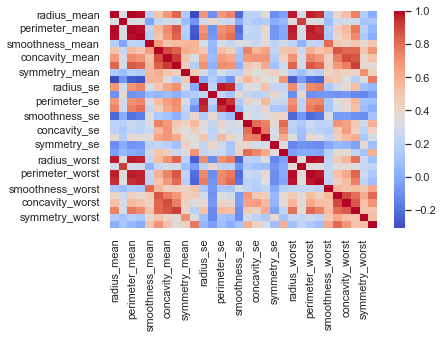

In [5]:
sns.heatmap(df.corr(), cmap='coolwarm');

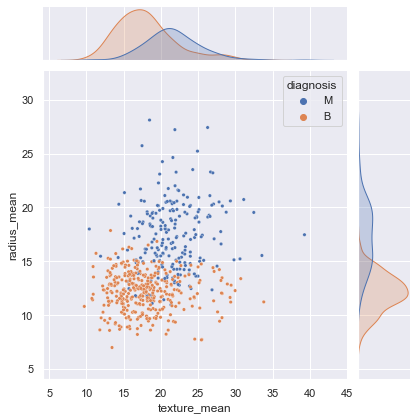

In [6]:
sns.jointplot(data=df, x='texture_mean', y='radius_mean', hue='diagnosis', s=12);

Uma pergunta é bastante importante:

In [7]:
df['diagnosis'].value_counts(True) * 100

B    62.741652
M    37.258348
Name: diagnosis, dtype: float64

Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [8]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [9]:
y.unique()

array(['M', 'B'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

In [11]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

df = pd.read_csv('../datasets/breast_cancer.csv')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

[[71  1]
 [ 4 38]]


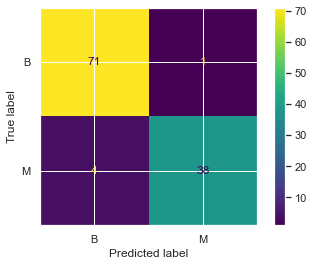

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [14]:
y_pred_test = knn.predict(X_test_ss)
print(confusion_matrix(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))

[[284   1]
 [  9 161]]


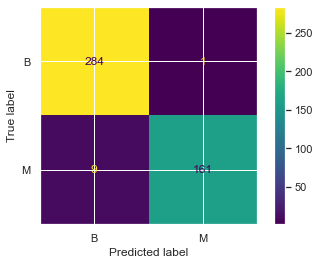

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [15]:
y_pred_train = knn.predict(X_train_ss)
print(confusion_matrix(y_train, y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

In [16]:
knn.kneighbors(X_test_ss[0].reshape(1,-1))

(array([[1.59659162, 1.91559863, 2.00607687, 2.0694831 , 2.07061232]]),
 array([[236, 164, 428,  98,  34]]))

In [17]:
X_train.iloc[[236, 428, 164,  34,  98]]

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
271,8910748,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,...,12.32,16.18,78.27,457.5,0.1358,0.1507,0.12750,0.08750,0.2733,0.08022
527,91813702,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,13.61,19.27,87.22,564.9,0.1292,0.2074,0.17910,0.10700,0.3110,0.07592
48,857155,12.05,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.02749,0.1675,...,13.76,20.70,89.88,582.6,0.1494,0.2156,0.30500,0.06548,0.2747,0.08301
390,90317302,10.26,12.22,65.75,321.6,0.09996,0.07542,0.01923,0.01968,0.1800,...,11.38,15.65,73.23,394.5,0.1343,0.1650,0.08615,0.06696,0.2937,0.07722
158,871122,12.06,12.74,76.84,448.6,0.09311,0.05241,0.01972,0.01963,0.1590,...,13.14,18.41,84.08,532.8,0.1275,0.1232,0.08636,0.07025,0.2514,0.07898


In [18]:
y_train.iloc[[236, 428, 164,  34,  98]]

271    B
527    B
48     B
390    B
158    B
Name: diagnosis, dtype: object

__________

Vamos fazer também a validação cruzada!

Mas uma importante alteração é necessária... Se fizermos como antes, usando o target original diretamente:

```python
from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)
```
Teremos um erro (teste!)

In [ ]:
from sklearn.model_selection import KFold, cross_validate

df = pd.read_csv('../datasets/breast_cancer.csv')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

group = KFold(n_splits=10, shuffle=True, random_state=42)

metric = 'f1'

results =  cross_validate(estimator=knn, X=X_train, y=y_train,
                            cv=group, scoring=metric, return_train_score=True)

Não há problema algum em utilizar as classes originais quando deseja-se avaliar o modelo final com a matriz de confusão ou o classification_report. Internamente, é feita um mapeamento pra 0 e 1.

Mas, pra usar o cross_validate, este mapa não é feito. Daí, é necessário que seja explicitamente indicada este mapeamento. Pra fazer isso, há duas opções:

- 1 - Fazer o mapeamento explicitamente e depois usar o código extamente como acima;
- 2 - Indicar qual é a classe positiva (valor 1) na hora de indicar a métrica a ser calculada -- mas pra isso, a função respectiva da métrica deve ser usada, junto com o argumento `pos_label`

Vejamos ambas as opções:

In [20]:
#mapeamento explícito dos dados
y_train.map({'B':0,'M':1})

df = pd.read_csv('../datasets/breast_cancer.csv')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
y_num = y.map({'B':0,'M':1})

X_train, X_test, y_train, y_test = train_test_split(X, y_num, test_size=0.2, stratify=y, random_state=42)

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

knn = KNeighborsClassifier()

group = KFold(n_splits=10, shuffle=True, random_state=42)

metric = 'f1'

results =  cross_validate(estimator=knn, X=X_train, y=y_train,
                            cv=group, scoring=metric, return_train_score=True)

print(results)

{'fit_time': array([0.00250721, 0.00269222, 0.00238109, 0.00240588, 0.00285316,
       0.00307512, 0.0024972 , 0.00276828, 0.00356603, 0.00253606]), 'score_time': array([0.00573587, 0.00621986, 0.00668311, 0.00571513, 0.00629401,
       0.00570917, 0.00668693, 0.00641489, 0.00833368, 0.00651789]), 'test_score': array([0.35294118, 0.61111111, 0.38709677, 0.59259259, 0.52631579,
       0.62068966, 0.73684211, 0.75      , 0.52173913, 0.46666667]), 'train_score': array([0.73722628, 0.74698795, 0.72222222, 0.71875   , 0.75182482,
       0.71713147, 0.75193798, 0.73846154, 0.75812274, 0.75862069])}


In [21]:
# segunda abordagem

from sklearn.metrics import make_scorer, f1_score

df = pd.read_csv('../datasets/breast_cancer.csv')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

group = KFold(n_splits=10, shuffle=True, random_state=42)

# inserimos a metrica e o label positivo
metric = make_scorer(f1_score, pos_label='M')

results =  cross_validate(estimator=knn, X=X_test_ss, y=y_test,
                            cv=group, scoring=metric, return_train_score=True)
pd.DataFrame(results)


,fit_time,score_time,test_score,train_score
0,0.000730,0.003026,1.000000,0.957746
1,0.000825,0.002541,0.857143,0.972973
2,0.000736,0.002427,0.909091,0.972222
3,0.000764,0.002580,0.750000,0.972222
4,0.000833,0.002219,0.666667,0.974359
5,0.000828,0.002381,1.000000,0.942857
6,0.000706,0.002258,1.000000,0.960000
7,0.000761,0.002456,1.000000,0.974359
8,0.000781,0.002898,1.000000,0.972973
9,0.000753,0.002188,1.000000,0.972222


O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


Fazendo tudo numa única célula:

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

Podemos testar também o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [22]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)

X_train_mms = rs.transform(X_train)
X_test_mms = rs.transform(X_test)

**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!

____

## <span id='1' style='color:Gold'>2) Ferramentas especiais


Vamos agora ver algumas ferramentas especiais do sklearn que nos ajudam no desenvolvimento de modelos!

### Pipeline

O [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) é uma estrutura que o sklearn proporciona a fim de garantir que possamos em uma única estrutura passar **o estimador e o transformador** (e muitas outras coisas). Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/compose.html#pipeline). 

Vamos ver a seguir como esta estrutura funciona:

In [23]:
# read data
df = pd.read_csv('../datasets/breast_cancer.csv')
# define features/target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# define Scaler
ss = StandardScaler().fit(X_train)
# normalize data
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)
# fit model
knn = KNeighborsClassifier().fit(X_train_ss, y_train)
# define groups
group = KFold(n_splits=10, shuffle=True, random_state=42)
# define metrics
metric = make_scorer(f1_score, pos_label='M')
# generate results
results =  cross_validate(estimator=knn, X=X_test_ss, y=y_test,
                            cv=group, scoring=metric, return_train_score=True)
pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.000689,0.002323,1.000000,0.957746
1,0.000776,0.002281,0.857143,0.972973
2,0.000724,0.002287,0.909091,0.972222
3,0.000768,0.002489,0.750000,0.972222
4,0.000733,0.002290,0.666667,0.974359
5,0.001189,0.002406,1.000000,0.942857
6,0.001128,0.002933,1.000000,0.960000
7,0.001169,0.002342,1.000000,0.974359
8,0.000755,0.002341,1.000000,0.972973
9,0.000732,0.002163,1.000000,0.972222


In [24]:
from sklearn.pipeline import Pipeline

In [25]:
lista_etapas =[
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())
            ]
            
pipe = Pipeline(lista_etapas)

In [26]:
# read data
df = pd.read_csv('../datasets/breast_cancer.csv')
# define features/target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# CREATE PIPELINE
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
]).fit(X_train, y_train)
# define groups
group = KFold(n_splits=10, shuffle=True, random_state=42)
# define metrics
metric = make_scorer(f1_score, pos_label='M')
# generate results - add pipeline
results =  cross_validate(estimator=pipeline, X=X_test_ss, y=y_test,
                            cv=group, scoring=metric, return_train_score=True)
pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001684,0.002496,1.000000,0.957746
1,0.001325,0.003068,0.857143,0.960000
2,0.001418,0.002488,0.909091,0.972973
3,0.001774,0.002431,0.750000,0.972222
4,0.001377,0.002326,0.666667,0.987342
5,0.001624,0.002455,0.750000,0.942857
6,0.001315,0.002377,1.000000,0.960000
7,0.001357,0.002886,1.000000,0.962025
8,0.001788,0.002402,1.000000,0.945946
9,0.001400,0.002365,1.000000,0.958904


In [28]:
from sklearn.model_selection import StratifiedKFold
# read data
df = pd.read_csv('../datasets/breast_cancer.csv')
# define features/target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# CREATE PIPELINE
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
]).fit(X_train, y_train)
# define groups
group = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# define metrics
metric = make_scorer(f1_score, pos_label='M')
# generate results - add pipeline
results =  cross_validate(estimator=pipeline, X=X_test_ss, y=y_test,
                            cv=group, scoring=metric, return_train_score=True)
pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001892,0.003423,1.000000,0.960000
1,0.001499,0.003186,0.857143,0.960000
2,0.001864,0.004333,0.750000,0.972222
3,0.002023,0.005841,0.888889,0.958904
4,0.002813,0.004351,0.857143,0.986667
5,0.001488,0.004541,1.000000,0.960000
6,0.004030,0.002704,1.000000,0.960000
7,0.004023,0.003464,1.000000,0.945946
8,0.002369,0.005811,1.000000,0.972973
9,0.001973,0.003593,1.000000,0.960000


______

### Gridsearch

O [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) é uma estrutura que o sklearn proporciona para que seja feita **a busca exaustiva de hiperparâmetros de um estimador**.

Na prática, o que o gridsearch faz é **treinar diversos modelos com diferentes combinações de hiperparâmetros**, de modo a manter o melhor deles como o modelo final, tudo automaticamente! 

Tudo o que precisamos fazer é indicar quais os hiperparâmetros que queremos procurar: a **grade**!

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

É muito comum também passarmos o **Pipeline** como argumento do gridsearch!

Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). 

Vamos ver a seguir como esta estrutura funciona:

O Gridsearch avalia o melhor modelo segundo a métrica que passamos em `scoring`. [Clique aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para ver as métricas disponíveis por padrão.

Mas o GS vai além: ele não calcula a métrica uma única vez, mas sim **várias vezes**, conforme especificado pelo parâmetro `cv`. No fim, o melhor modelo é o que tem o melhor scoring **médio** entre as vezes que é calculado.

O "cv" quer dizer **Cross Validation**, o método mais seguro de realizar um treinamento e avaliação de um modelo que conhecemos na aula passada!

<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600> 

Com a validação cruzada, garantimos uma avaliação justa de cada um dos modelos candidatos (cada um construído com uma combinação diferente de hiperparâmetros).

Assim, sabemos que a melhor combinação de hiperparâmetros a ser encontrada não estará de qualquer forma "overfitada" em particularidades da base de treino!

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
# read data
df = pd.read_csv('../datasets/breast_cancer.csv')
# define features/target
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
# CREATE PIPELINE
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
]).fit(X_train, y_train)
# define groups
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

from sklearn.model_selection import GridSearchCV
# define grid parameters
# synthax: '[object_id]__[hyperparameter_name]': [values]
parameters = {
        'knn__weights' : ['uniform','distance'],
        'knn__metric' : ['manhattan','euclidean'],
        'knn__n_neighbors' : range(2, 21)
    }
# define grid metric to evaluate
metrics = make_scorer(recall_score, pos_label = 'M' )
# create grid object
grid_knn = GridSearchCV(estimator = pipeline, 
                    param_grid = parameters, 
                    scoring = metrics,
                    cv = splitter,
                    verbose = 1, 
                    #refit=[metric_name] or [bool] #used for multiple metrics
                    )
# fit all models
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=M), verbose=1)

O GS treinado tem diversos atributos super úteis e interessantes! Vamos dar uma olhada neles:

`.best_estimator_`: retorna quais as escolhas do Pipeline que produziram o melhor modelo. No que diz respeito ao modelo, temos exatamente quais os parâmetros escolhidos!

In [44]:
grid_knn.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

`.best_params_`: retorna os parâmetros testados na grade que produziram o melhor modelo.

In [45]:
grid_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

`.best_score_`: retorna a **média cross-validada da métrica de interesse** do melhor modelo. Como esse é o valor médio construído usando CV, este é estatisticamente o valor mais realístico a ser atribuído à performance do modelo!

In [46]:
grid_knn.best_score_

0.9411764705882353

`.cv_results_`: diversas informações do processo feito pelo GS

In [42]:
grid_results_df = pd.DataFrame(grid_knn.cv_results_)
grid_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017594,0.009943,0.020395,0.011713,manhattan,2,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.882353,...,1.0,0.882353,0.823529,0.764706,1.0,0.941176,0.882353,0.905882,0.070588,46
1,0.025877,0.015214,0.011078,0.006205,manhattan,2,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.882353,...,1.0,0.941176,0.882353,0.823529,1.0,0.941176,0.882353,0.929412,0.057635,8
2,0.015222,0.005343,0.015617,0.004011,manhattan,3,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.000000,0.941176,0.941176,0.074407,1
3,0.010112,0.002584,0.008315,0.003722,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.000000,0.941176,0.941176,0.074407,1
4,0.006911,0.001857,0.011581,0.003488,manhattan,4,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.882353,0.823529,0.764706,1.0,0.941176,0.941176,0.923529,0.079139,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.005711,0.000977,0.004610,0.000534,euclidean,18,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",1.000000,0.823529,...,1.0,0.823529,0.823529,0.764706,1.0,1.000000,0.882353,0.911765,0.092073,30
72,0.005501,0.001007,0.006874,0.000988,euclidean,19,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",1.000000,0.823529,...,1.0,0.823529,0.823529,0.764706,1.0,1.000000,0.882353,0.905882,0.088039,46
73,0.005484,0.000623,0.004340,0.000236,euclidean,19,distance,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",1.000000,0.823529,...,1.0,0.823529,0.823529,0.764706,1.0,1.000000,0.882353,0.905882,0.088039,46
74,0.005362,0.000788,0.006460,0.000456,euclidean,20,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.764706,0.823529,0.764706,1.0,1.000000,0.823529,0.888235,0.092822,74


In [48]:
grid_results_df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.015222,0.005343,0.015617,0.004011,manhattan,3,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.0,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.0,0.941176,0.941176,0.074407,1
3,0.010112,0.002584,0.008315,0.003722,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.0,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.0,0.941176,0.941176,0.074407,1
5,0.009301,0.002713,0.008519,0.002660,manhattan,4,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.0,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.0,0.941176,0.941176,0.074407,1
6,0.006926,0.001882,0.010388,0.001985,manhattan,5,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.0,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.0,0.941176,0.941176,0.074407,1
7,0.007184,0.001117,0.008008,0.001195,manhattan,5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.0,0.882353,...,1.0,0.941176,0.882353,0.764706,1.0,1.0,0.941176,0.941176,0.074407,1


____________

Podemos mudar a métrica segundo a qual otimizaremos os hiperparâmetros!

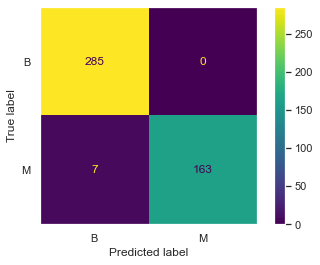

              precision    recall  f1-score   support

           B       0.98      1.00      0.99       285
           M       1.00      0.96      0.98       170

    accuracy                           0.98       455
   macro avg       0.99      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455



In [52]:
y_pred_train = grid_knn.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.grid(False)
plt.show()

print(classification_report(y_train, y_pred_train))

### Exercício

Sua vez! Faça agora uma estrutura de Pipeline + GS para o Logit, e depois compare o melhor logit com o melhor knn. Qual é o melhor modelo final?

In [27]:
# pra casa
# teste l1, l2 e elastic net!!

____

## <span id='1' style='color:Gold'>3) KNN para regressão




O KNN é nosso primeiro exemplo de algoritmo que pode ser utilizado para ambos os problemas de classificação e regressão!

A ideia é bem simples: o target atribuído a uma nova observação é igual à **média do target das $k$ observações mais próximas**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

Naturalmente, também para regressão o parâmetro $k$ e a métrica de distância são hiperparâmetros importantes:

<img src="https://i.stack.imgur.com/gAILq.png" width=500>

A classe no sklearn é a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Dê uma olhada no User Guide e também no [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [56]:
df_houses = pd.read_csv('../datasets/house_prices.csv')
df_houses = df_houses.select_dtypes(include=np.number).dropna()

X = df_houses.drop(['Id','SalePrice'], axis=1)
y = df_houses['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [62]:
df_houses

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [60]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knr', KNeighborsRegressor())
]).fit(X_train, y_train)

splitter = KFold(n_splits = 10, shuffle = True, random_state = 42)

parameters = {
        'knr__weights' : ['uniform','distance'],
        'knr__metric' : ['manhattan','euclidean'],
        'knr__n_neighbors' : range(2, 21)
    }

metrics = 'neg_mean_absolute_error'

grid_knn_reg = GridSearchCV(estimator = pipeline, 
                    param_grid = parameters, 
                    scoring = metrics,
                    cv = splitter,
                    verbose = 1, 
                    #refit=[metric_name] or [bool] #used for multiple metrics
                    )
# fit all models
grid_knn_reg.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits


/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/metaestimator

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knr', KNeighborsRegressor())]),
             param_grid={'knr__metric': ['manhattan', 'euclidean'],
                         'knr__n_neighbors': range(2, 21),
                         'knr__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=1)

In [59]:
grid_knn.best_params_

{'knr__metric': 'manhattan', 'knr__n_neighbors': 2, 'knr__weights': 'uniform'}

In [61]:
grid_knn.best_score_

nan